<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Quora-Insincere-Text-Classification" data-toc-modified-id="Quora-Insincere-Text-Classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Quora Insincere Text Classification</a></span><ul class="toc-item"><li><span><a href="#Preprocessing---Vocabulary-/-Pretrained-Word-Embedding" data-toc-modified-id="Preprocessing---Vocabulary-/-Pretrained-Word-Embedding-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preprocessing - Vocabulary / Pretrained Word Embedding</a></span></li><li><span><a href="#Data-Loading" data-toc-modified-id="Data-Loading-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Loading</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Prediction</a></span></li><li><span><a href="#Submission" data-toc-modified-id="Submission-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Submission</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))
from formats import load_style
load_style(plot_style = False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

# prevent scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,torch,keras,spacy

Using TensorFlow backend.


Ethen 2020-01-30 22:28:14 

CPython 3.6.4
IPython 7.9.0

numpy 1.16.5
pandas 0.25.0
sklearn 0.21.2
matplotlib 3.1.1
torch 1.3.1
keras 2.2.2
spacy 2.1.6


# Quora Insincere Text Classification

In [3]:
submission_dir = '.'
data_dir = os.path.join('data', 'quora-insincere-questions-classification')
os.listdir(data_dir)

['embeddings',
 'test.csv',
 'train.csv',
 'embeddings.zip',
 'sample_submission.csv']

In [4]:
print('available pretrained embeddings:')
embeddings_dir = os.path.join(data_dir, 'embeddings')
os.listdir(embeddings_dir)

available pretrained embeddings:


['GoogleNews-vectors-negative300',
 'paragram_300_sl999',
 'glove.840B.300d',
 'wiki-news-300d-1M']

In [5]:
train_path = os.path.join(data_dir, 'train.csv')
test_path = os.path.join(data_dir, 'test.csv')

df = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
print('full data shape: ', df.shape)
print('test shape:', df_test.shape)
df.head()

full data shape:  (1306122, 3)
test shape: (375806, 2)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


We can observe an class imbalance, meaning out of all of questions provided, only 6% of them are labeled as insincere.

In [6]:
text_col = 'question_text'
label_col = 'target'

df[label_col].value_counts() / df.shape[0]

0   0.938
1   0.062
Name: target, dtype: float64

## Preprocessing - Vocabulary / Pretrained Word Embedding

We leverage spacy's tokenizer to tokenize our raw text into a space delimited text. As spacy's tokenizer is a lot more expensive compared to splitting on white-spaces, we'll perform it once for our raw text so we don't have to repeat this expensive process again.

In [0]:
import spacy

nlp = spacy.load('en', disable=['parser', 'ner', 'tagger'])

In [9]:
labels = df[label_col].values

texts = []
for text in tqdm(df[text_col]):
    doc = nlp.tokenizer(text)
    tokenized_text = ' '.join(token.text for token in doc)
    texts.append(tokenized_text)

100%|██████████| 1306122/1306122 [07:01<00:00, 3099.87it/s]


In [10]:
random_state = 1234
val_split = 0.1

texts_train, texts_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_split,
    random_state=random_state)

print('train size: ', len(texts_train))
print('validation size: ', len(texts_val))

train size:  1175509
validation size:  130613


Here we've implemented a custom tokenizer, the motivation for doing so was due to the fact at the time of writing this, keras' tokenizer did not have a `min_freq` option, meaning we could not tell the tokenizer to only retain words/tokens that have appeared in the corpus for more than `min_freq` number of times.

In [0]:
from operator import itemgetter


class Vocab:

    def __init__(self, tokenizer=None, max_vocab_size=None, min_count=2,
                 unk_token=None, pad_token='<pad>'):
        self.tokenizer = tokenizer
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.unk_token = unk_token
        self.pad_token = pad_token

    def fit(self, texts):
        if self.tokenizer is None:
            self.tokenizer_ = whitespace_tokenizer
        else:
            self.tokenizer_ = self.tokenizer

        index2word, word2index = self.learn_vocab(texts)
        self.index2word_ = index2word
        self.word2index_ = word2index
        self.vocab_size_ = len(word2index)
        return self

    def learn_vocab(self, texts):
        tokenizer = self.tokenizer_

        word_counts = {}
        for text in texts:
            words = tokenizer(text)
            for word in words:
                count = word_counts.get(word, 0)
                word_counts[word] = count + 1

        sorted_word_counts = sorted(word_counts.items(), key=itemgetter(1), reverse=True)

        index2word = []
        if self.pad_token:
            index2word.append(self.pad_token)
        if self.unk_token:
            index2word.append(self.unk_token)

        for word, count in sorted_word_counts:
            if count < self.min_count or len(index2word) == self.max_vocab_size:
                break

            index2word.append(word)

        word2index = {word: index for index, word in enumerate(index2word)}
        return index2word, word2index

    def texts_to_sequences(self, texts):
        tokenizer = self.tokenizer_
        word2index = self.word2index_
        if self.unk_token:
            unk_index = word2index[self.unk_token]

        sequences = []
        for text in texts:
            words = tokenizer(text)
            sequence = []
            for word in words:
                index = word2index.get(word)
                if index is not None:
                    sequence.append(index)
                elif self.unk_token:
                    sequence.append(unk_index)

            sequences.append(sequence)

        return sequences


def whitespace_tokenizer(text):
    return text.split(' ')

In [12]:
vocab = Vocab(min_count=2)
vocab.fit(texts_train)
print('vocab size: ', vocab.vocab_size_)

vocab size:  106145


We can plot the distribution of the text length to understand some characteristics about our text data.

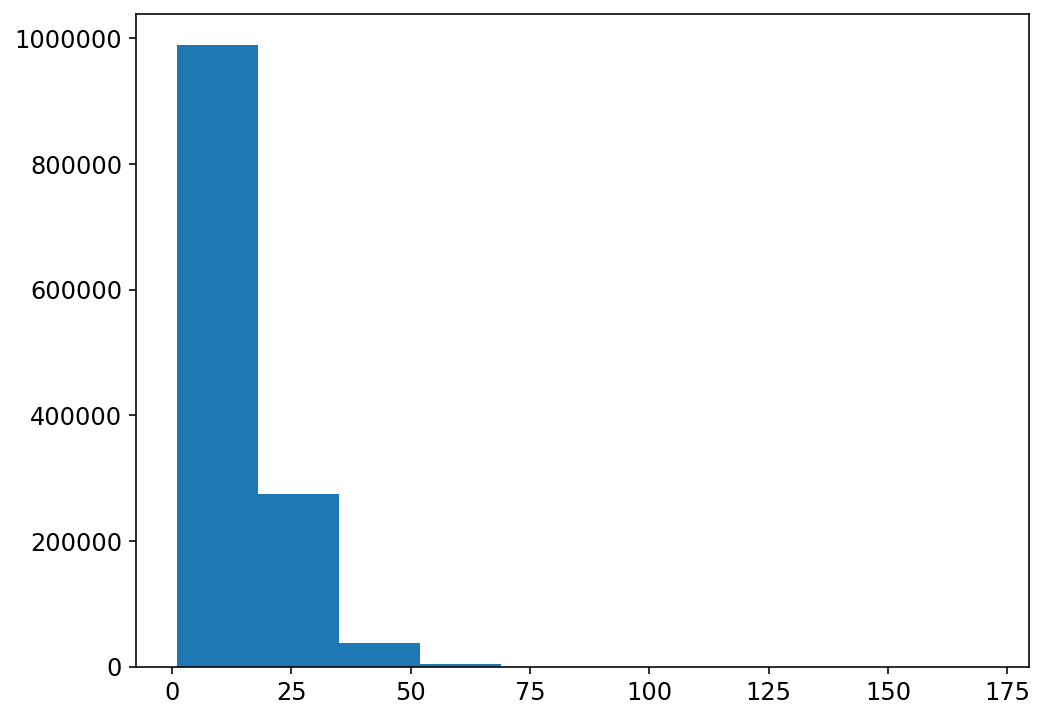

In [13]:
texts_lens = np.array([len(text.split(' ')) for text in texts])

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

plt.hist(texts_lens)
plt.ylabel('')
plt.xlabel('text lengths')
plt.title('')
plt.show()

This is the part where we should avoid padding the entire text data to a fixed length. Doing so will be suboptimal because when iterating over the dataset in a batched fashion, there will be some batches where the length of all its samples is smaller than the fixed length we've specified. We will deal with padding our tokenized text data in a batch by batch manner later down the road.

In [0]:
tokenized_train = vocab.texts_to_sequences(texts_train)
tokenized_val = vocab.texts_to_sequences(texts_val)

# in other words, a lot of examples do the following, don't do this
# max_len = 72
# X_train = pad_sequences(tokenized_train, maxlen=max_len)
# X_val = pad_sequences(tokenized_val, maxlen=max_len)

We now load one of the pre-trained embedding.

In [0]:
def get_embedding_lookup(embedding_path, embed_size=300, encoding='utf8'):
    error_lines = {}
    embedding_lookup = {}
    with open(embedding_path, encoding=encoding, errors='ignore') as f:
        for idx, line in tqdm(enumerate(f)):
            try:
                values = line.split(' ')
                word = values[0]
                coef = np.array(values[1:], dtype=np.float32)
                if coef.shape[0] != embed_size:
                    raise ValueError('embedding size does not match', embed_size)

                embedding_lookup[word] = coef
            except ValueError:
                error_lines[idx] = line

    return embedding_lookup, error_lines

In [17]:
# embedding vocab size : 2,196,016
glove_embedding_path = os.path.join(embeddings_dir, 'glove.840B.300d', 'glove.840B.300d.txt')
glove_embedding_lookup, glove_error_lines = get_embedding_lookup(glove_embedding_path)
print('glove embedding vocab size: ', len(glove_embedding_lookup))

2196017it [02:40, 13664.61it/s]

glove embedding vocab size:  2196016


Vocabularies that are not found in the pre-trained embeddings are initalized to some random numbers draw from a normal distribution with the mean and standard deviation of the whole pre-trained embedding. The next 2 code chunk computes the mean and standard deviation for the whole pre-trained embedding. Note that in pratice, we can also hard-code these values for pre-trained embeddings that we've already worked with to speed up this process.

In [0]:
def compute_embedding_mean_std(embedding_lookup):
    embedding = np.stack(list(embedding_lookup.values()))
    return embedding.mean(), embedding.std()

In [19]:
start_time = time.time()

# we can replace the computation with hard-coded mean and standardization for the
# glove pre-trained embedding
glove_embed_mean, glove_embed_std = compute_embedding_mean_std(glove_embedding_lookup)

elapsed = time.time() - start_time
print('elapsed', elapsed)

elapsed 7.8451313972473145


The following section highlights one of the main learnings of the competition. So while looking up pre-trained embeddings for our vocabulary, we try using different variations of the word to see if it results in a match. For example, here we capitalize, uppercase, lowercase, use various stemming. The core idea behind it is to make sure we can leverage pre-trained embedding as much as possible, and this approach can be used if we don't have easy access to the preprocessing method that's used by the people that trained the embeddings that we're planning to leverage.

There're many ways in which we can preprocess our raw text data. For example, during this competition, a lot of [kernels](https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2) hard-coded a dictionary that contains contraction mappings such as `{"could've": "could have"}`. Or create custom tokenization rules to split the numbers and punctuations.

Creating/preprocessing the vocabulary is an iterative process, if we find that we can increase the coverage by including some additional logic, then we can try and see if it does in fact increase coverage and whether it leads to some downstream performance gain. In this notebook, we just went with spacy tokenizer, use your own personal judgment to measure whether the effort is worth it to go down the customization route. 

In [0]:
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer

porter_stemmer = PorterStemmer()
lancaster_stemmer = LancasterStemmer()
snowball_stemmer = SnowballStemmer("english")

In [0]:
def get_pretrained_embedding(embedding_lookup, word2index, vocab_size, embed_size, embed_mean, embed_std):
    n_vocab_found = 0
    embed_shape = (vocab_size, embed_size)
    pretrained_embedding = np.random.normal(embed_mean, embed_std, embed_shape).astype(np.float32)
    for word, index in word2index.items():
        if index >= vocab_size:
            continue

        embedding_vector = embedding_lookup.get(word)
        if embedding_vector is not None:
            pretrained_embedding[index] = embedding_vector
            n_vocab_found += 1
            continue

        # if we can't find the original word in the pre-trained
        # embedding lookup, then try different variations to
        # see if we can find it.
        # There're a lot of duplicated code here that can be polished
        embedding_vector = embedding_lookup.get(word.lower())
        if embedding_vector is not None:
            pretrained_embedding[index] = embedding_vector
            n_vocab_found += 1
            continue

        embedding_vector = embedding_lookup.get(word.upper())
        if embedding_vector is not None:
            pretrained_embedding[index] = embedding_vector
            n_vocab_found += 1
            continue

        embedding_vector = embedding_lookup.get(word.capitalize())
        if embedding_vector is not None:
            pretrained_embedding[index] = embedding_vector
            n_vocab_found += 1
            continue

        embedding_vector = embedding_lookup.get(porter_stemmer.stem(word))
        if embedding_vector is not None:
            pretrained_embedding[index] = embedding_vector
            n_vocab_found += 1
            continue

        embedding_vector = embedding_lookup.get(snowball_stemmer.stem(word))
        if embedding_vector is not None:
            pretrained_embedding[index] = embedding_vector
            n_vocab_found += 1
            continue

        embedding_vector = embedding_lookup.get(lancaster_stemmer.stem(word))
        if embedding_vector is not None:
            pretrained_embedding[index] = embedding_vector
            n_vocab_found += 1
            continue

    vocab_found_ratio = n_vocab_found / vocab_size
    print('Found embeddings for {:.2%} of vocab'.format(vocab_found_ratio))
    return pretrained_embedding

In [22]:
embed_size = 300
glove_pretrained_embedding = get_pretrained_embedding(glove_embedding_lookup, vocab.word2index_,
                                                      vocab.vocab_size_, embed_size,
                                                      glove_embed_mean, glove_embed_std)

Found embeddings for 94.53% of vocab


This technique is used by the [3rd place kernel](https://www.kaggle.com/c/quora-insincere-questions-classification/discussion/80495). It even went above and beyond what's implemented here, and tried to perform spell checking, spacy lemmaization to increase of vocabulary coverage.

## Data Loading

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The next few code chunk involves understanding how to work with [Pytorch's Dataset and DataLoader](https://pytorch.org/docs/stable/data.html). The main customization that we are doing here is to provide our own implementation of `collate_fn`, where given a batch of dataset, we pad our batch of text data to either the maximum text length that occurs within that data (in the implementation, it contains a parameter to specify the length percentage).

In [0]:
class LabeledDataset(Dataset):

    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __getitem__(self, index):
        return self.texts[index], self.labels[index]

    def __len__(self):
        return len(self.texts)

In [0]:
class LabeledCollate:

    def __init__(self, max_len, pad_index, device, percentage=100):
        self.device = device
        self.max_len = max_len
        self.pad_index = pad_index
        self.percentage = percentage

    def __call__(self, batch):
        texts, labels = zip(*batch)

        texts_len = [len(text) for text in texts]
        texts_len_percentile = int(np.percentile(texts_len, self.percentage))
        max_len = min(texts_len_percentile, self.max_len)

        padded_texts = pad_sequences(texts, maxlen=max_len, value=self.pad_index)
        texts = torch.LongTensor(padded_texts).to(self.device)   
        labels = torch.FloatTensor(labels).to(self.device)       
        return texts, labels

In [26]:
max_len = 72
batch_size = 256

pad_index = vocab.word2index_[vocab.pad_token]
print('padding index: ', pad_index)

collate_fn = LabeledCollate(max_len, pad_index, device)
dataset_train = LabeledDataset(tokenized_train, y_train)
dataset_val = LabeledDataset(tokenized_val, y_val)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
data_loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

padding index:  0


We can print out one batch from the dataloader to confirm the size/shape
is as expected.

In [27]:
x_batch, y_batch = next(iter(data_loader_val))
x_batch

tensor([[    0,     0,     0,  ...,    33, 34125,     1],
        [    0,     0,     0,  ..., 47667,   428,     1],
        [    0,     0,     0,  ...,    15,   352,     1],
        ...,
        [    0,     0,     0,  ...,   251,  8690,     1],
        [    0,     0,     0,  ...,     9,  1367,     1],
        [    0,     0,     0,  ...,  1606, 56350,     1]], device='cuda:0')

In [28]:
x_batch.shape

torch.Size([256, 54])

## Model

Deep learning frameworks gives us the flexibility to define the [architectures](https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/) suitable for the text classification task at hand. During this competition, popular architectures include Bi-Directional LSTM/GRU and attention layer.

The idea behind attention mechanism is that not all words in the sentence contribute equally to the task. Hence, we introduce an attention layer within our architecture so that the model can learn when does a word contribute more to the prediction.

Please refer to the following paper for more context.
[Paper: Z. Yang, D. Tang, C. Dyer, X. He, A, Smola, E. Hovy - Hierarchical Attention Networks for Document Classification (2016)](https://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf)

In [0]:
class Attention(nn.Module):
    """
    A lot of examples on the internet implements the attention layer without
    the context vector, which is different from the notation that is mentioned
    in the paper hierachical attention network.
    """

    def __init__(self, feature_size):
        super().__init__()
        self.feature_size = feature_size

        self.weight = nn.Linear(feature_size, 1)

    def forward(self, inputs):
        # inputs : [batch size, sequence len, hidden size * num directions]
        seq_len = inputs.shape[1]
        reshaped_inputs = inputs.contiguous().view(-1, self.feature_size)

        # [batch size, sequence len]
        uit = torch.tanh(self.weight(reshaped_inputs)).view(-1, seq_len)

        # [batch size, sequence len]
        ait = torch.softmax(uit, dim=-1)
        # [batch size, sequence len, 1]
        ait_reshaped = torch.unsqueeze(ait, dim=-1)

        # [batch size, hidden layer]
        weighted_inputs = torch.sum(ait_reshaped * inputs, dim=1)
        return weighted_inputs, ait

    def extra_repr(self):
        return 'feature_size={}'.format(self.feature_size)

In [0]:
class AttentionWithContext(nn.Module):

    def __init__(self, feature_size, attention_size):
        super().__init__()
        self.feature_size = feature_size
        self.attention_size = attention_size

        self.weight = nn.Linear(feature_size, attention_size)
        self.context = nn.Linear(attention_size, 1)

    def forward(self, inputs):
        # inputs : [batch size, sequence len, hidden size * num directions]
        seq_len = inputs.shape[1]
        reshaped_inputs = inputs.contiguous().view(-1, self.feature_size)

        # [batch size * sequence len, attention size]
        uit = torch.tanh(self.weight(reshaped_inputs))

        # [batch size, sequence len]
        ait = self.context(uit).view(-1, seq_len)

        # [batch size, sequence len]
        ait = torch.softmax(ait, dim=-1)
        # [batch size, sequence len, 1]
        ait_reshaped = torch.unsqueeze(ait, dim=-1)

        # [batch size, hidden layer]
        weighted_inputs = torch.sum(ait_reshaped * inputs, dim=1)
        return weighted_inputs, ait

    def extra_repr(self):
        repr_str = 'feature_size={}, attention_size={}'
        return repr_str.format(self.feature_size, self.attention_size)

In [0]:
class TextAttentionLSTM(nn.Module):

    def __init__(self, num_class, vocab_size=None, embed_size=300,
                 n_layers=2, hidden_size=128, linear_size=256, attention_size=100,
                 pretrained_embedding=None, freeze=True):
        super().__init__()
        self.num_class = num_class
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.linear_size = linear_size
        self.attention_size = attention_size

        if pretrained_embedding is None:
            self.embedding = nn.Embedding(vocab_size, embed_size)
            self.vocab_size = vocab_size
            self.embed_size = embed_size
        else:
            self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(pretrained_embedding), freeze=freeze)
            self.vocab_size = self.embedding.num_embeddings
            self.embed_size = self.embedding.embedding_dim

        self.lstm = nn.LSTM(self.embed_size, hidden_size, n_layers, bidirectional=True, batch_first=True)
        self.attention = AttentionWithContext(hidden_size * 2, attention_size)
        self.linear = nn.Linear(hidden_size * 2, linear_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(linear_size, num_class)

    def forward(self, text):
        output, _ = self.forward_with_attention(text)
        return output

    def forward_with_attention(self, text):
        # embedded : [batch size, sent len, embed size]
        embedded = self.embedding(text)
        # output : [batch size, sent len, hidden size * num directions]
        # hidden : [n layers * n directions, batch size, hidden size]
        lstm_outputs, (lstm_hidden, lstm_cell) = self.lstm(embedded)
        weighted_lstm_outputs, attention = self.attention(lstm_outputs)
        dense = self.relu(self.linear(weighted_lstm_outputs))
        output = self.output(dense)
        return output, attention

In [0]:
class TextLSTM(nn.Module):

    def __init__(self, num_class, vocab_size=None, embed_size=300,
                 n_layers=2, hidden_size=128, linear_size=256,
                 pretrained_embedding=None, freeze=True):
        super().__init__()
        self.num_class = num_class
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.linear_size = linear_size

        if pretrained_embedding is None:
            self.embedding = nn.Embedding(vocab_size, embed_size)
            self.vocab_size = vocab_size
            self.embed_size = embed_size
        else:
            self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(pretrained_embedding), freeze=freeze)
            self.vocab_size = self.embedding.num_embeddings
            self.embed_size = self.embedding.embedding_dim

        self.lstm = nn.LSTM(self.embed_size, hidden_size, n_layers, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size * 2, linear_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(linear_size, num_class)

    def forward(self, text):
        # embedded : [batch size, sent len, embed size]
        embedded = self.embedding(text)
        # output : [batch size, sent len, hidden size * num directions]
        # hidden : [n layers * n directions, batch size, hidden size]
        lstm_outputs, (lstm_hidden, lstm_cell) = self.lstm(embedded)
        concated = torch.cat((lstm_hidden[-2, :, :], lstm_hidden[-1, :, :]), dim=1)
        dense = self.relu(self.linear(concated))
        output = self.output(dense)
        return output

In [78]:
num_class = 1

# both gave similar performance for this task
# glove_model = TextLSTM(num_class, pretrained_embedding=glove_pretrained_embedding).to(device)
glove_model = TextAttentionLSTM(num_class, pretrained_embedding=glove_pretrained_embedding).to(device)
glove_model

TextAttentionLSTM(
  (embedding): Embedding(106145, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, bidirectional=True)
  (attention): AttentionWithContext(feature_size=256)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=256, out_features=1, bias=True)
)

In [79]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(glove_model):,} trainable parameters')

The model has 927,333 trainable parameters


The next couple of code chunks involves defining functions to train the model, while training the model, we've although pass in the validation set to perform early stopping.

In [0]:
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()

    epoch_loss = 0.0
    epoch_acc = 0.0

    for x_batch, y_batch in data_loader:
        optimizer.zero_grad()
        y_output = model(x_batch).squeeze(dim=1)
        loss = criterion(y_output, y_batch)
        loss.backward()
        optimizer.step()

        acc = binary_accuracy(y_output, y_batch)
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [0]:
def binary_accuracy(y_output, y_true):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    # round predictions to the closest integer/label
    rounded_preds = torch.round(torch.sigmoid(y_output))
    correct = (rounded_preds == y_true).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [0]:
def evaluate_epoch(model, data_loader, criterion):
    model.eval()

    epoch_loss = 0.0
    epoch_acc = 0.0

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            y_output = model(x_batch).squeeze(dim=1)
            loss = criterion(y_output, y_batch)
            acc = binary_accuracy(y_output, y_batch)
            epoch_acc += acc.item()
            epoch_loss += loss.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [0]:
def train(model, data_loader_train, data_loader_val, criterion, optimizer,
          epochs=10, max_patience=1, model_checkpoint='model.pt'):

    best_val_loss = float('inf')
    for epoch in range(epochs):
        start_time = time.time()
        train_loss, train_acc = train_epoch(model, data_loader_train, criterion, optimizer)
        val_loss, val_acc = evaluate_epoch(model, data_loader_val, criterion)

        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60

        if val_loss < best_val_loss:
            patience = 0
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_checkpoint)
        else:
            patience += 1
            if patience > max_patience:
                break

        print('Epoch %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
        print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        print(f'\tLoss: {val_loss:.4f}(val)\t|\tAcc: {val_acc * 100:.1f}%(val)')

In [84]:
optimizer = optim.Adam(glove_model.parameters())
criterion = nn.BCEWithLogitsLoss()
glove_model_checkpoint = 'glove.pt'

train(glove_model, data_loader_train, data_loader_val, criterion, optimizer,
      model_checkpoint=glove_model_checkpoint)

glove_model.load_state_dict(torch.load(glove_model_checkpoint))

Epoch 1  | time in 1 minutes, 49 seconds
	Loss: 0.1119(train)	|	Acc: 95.6%(train)
	Loss: 0.1022(val)	|	Acc: 95.9%(val)
Epoch 2  | time in 1 minutes, 48 seconds
	Loss: 0.0972(train)	|	Acc: 96.1%(train)
	Loss: 0.0978(val)	|	Acc: 96.1%(val)
Epoch 3  | time in 1 minutes, 49 seconds
	Loss: 0.0897(train)	|	Acc: 96.4%(train)
	Loss: 0.0964(val)	|	Acc: 96.2%(val)
Epoch 4  | time in 1 minutes, 44 seconds
	Loss: 0.0822(train)	|	Acc: 96.7%(train)
	Loss: 0.0970(val)	|	Acc: 96.2%(val)


<All keys matched successfully>

## Prediction

The prediction part is somewhat similar to what we've did in the previous section. We tokenize the raw text from the test data, convert them into indices, then generate the predicted score for them.

In [85]:
texts_test = []
for text in tqdm(df_test[text_col]):
    doc = nlp.tokenizer(text)
    tokenized_text = ' '.join(token.text for token in doc)
    texts_test.append(tokenized_text)

100%|██████████| 375806/375806 [01:59<00:00, 3150.76it/s]


In [0]:
tokenized_test = vocab.texts_to_sequences(texts_test)

In [0]:
class UnlabeledDataset(Dataset):

    def __init__(self, texts):
        self.texts = texts

    def __getitem__(self, index):
        return self.texts[index]

    def __len__(self):
        return len(self.texts)


class UnlabeledCollate:

    def __init__(self, max_len, pad_index, device, percentage=100):
        self.device = device
        self.max_len = max_len
        self.pad_index = pad_index
        self.percentage = percentage

    def __call__(self, batch):
        texts_len = [len(text) for text in batch]
        texts_len_percentile = int(np.percentile(texts_len, self.percentage))
        max_len = min(texts_len_percentile, self.max_len)

        padded_batch = pad_sequences(batch, maxlen=max_len, value=self.pad_index)
        texts = torch.LongTensor(padded_batch).to(self.device)      
        return texts

In [0]:
def predict(model, X, pad_index, batch_size=512):
    dataset = UnlabeledDataset(X)
    collate_fn = UnlabeledCollate(max_len, pad_index, device)
    data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

    n_rows = len(X)
    predictions = np.zeros(n_rows)
    with torch.no_grad():
        idx = 0
        for x_batch in data_loader:
            y_output = model(x_batch).squeeze(dim=1)
            y_score = torch.sigmoid(y_output).cpu().numpy()

            start_idx = idx
            idx += batch_size
            end_idx = idx
            predictions[start_idx:end_idx] = y_score

            if end_idx == n_rows:
                break

    return predictions

In [89]:
y_pred_test = predict(glove_model, tokenized_test, pad_index)
y_pred_test

array([6.98427260e-01, 1.45648824e-04, 3.81290098e-04, ...,
       9.16973106e-04, 4.65367993e-05, 8.34513903e-02])

## Submission

Generating the submission involves finding the threshold that reaches the optimal f1 score on the validation set then using that threshold to generated the prediction label on the test set.

In [0]:
def create_submission(ids, predictions, ids_col, prediction_col, submission_path) -> pd.DataFrame:
    df_submission = pd.DataFrame({
        ids_col: ids,
        prediction_col: predictions
    }, columns=[ids_col, prediction_col])

    if submission_path is not None:
        # create the directory if need be, e.g. if the submission_path = submission/submission.csv
        # we'll create the submission directory first if it doesn't exist
        directory = os.path.split(submission_path)[0]
        if (directory != '' or directory != '.') and not os.path.isdir(directory):
            os.makedirs(directory, exist_ok=True)

        df_submission.to_csv(submission_path, index=False, header=True)

    return df_submission

In [0]:
import sklearn.metrics as metrics

def compute_score(y_true, y_score, verbose=True, round_digits=3):

    log_loss = round(metrics.log_loss(y_true, y_score), round_digits)

    precision, recall, threshold = metrics.precision_recall_curve(y_true, y_score)
    f1 = 2 * (precision * recall) / (precision + recall)

    mask = ~np.isnan(f1)
    f1 = f1[mask]
    precision = precision[mask]
    recall = recall[mask]

    best_index = np.argmax(f1)
    threshold = round(threshold[best_index], round_digits)
    precision = round(precision[best_index], round_digits)
    recall = round(recall[best_index], round_digits)
    f1 = round(f1[best_index], round_digits)

    if verbose:
        print('threshold: ', threshold)
        print('precision: ', precision)
        print('recall: ', recall)
        print('f1: ', f1)

    return {
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'log_loss': log_loss
    }

In [0]:
ids_col = 'qid'
prediction_col = 'prediction'
ids = df_test[ids_col]

In [93]:
# pretrained-embedding : glove f1 0.69
# no-pre-trained f1: 0.652
print('generating submission')
submission_path = os.path.join(submission_dir, 'submission.csv')

y_pred_val = predict(glove_model, tokenized_val, pad_index)
score_dict = compute_score(y_val, y_pred_val)

y_pred_test = predict(glove_model, tokenized_test, pad_index)
predictions = (y_pred_test > score_dict['threshold']).astype(np.int)
df_submission = create_submission(ids, predictions, ids_col, prediction_col, submission_path)

# sanity check to make sure the size and the output of the submission makes sense
print(df_submission.shape)
df_submission.head()

generating submission
threshold:  0.349
precision:  0.672
recall:  0.712
f1:  0.691
(375806, 2)


,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


The goal of this notebook was to introduce some of the biggest personal learnings/gains from the competition. We've achieved a f1 score of 0.69 on the validation set without getting into the ensembling territory.

There're other techniques that were seen in the discussion forum that can be worth trying if we wish to reproduce the performance of the winners.

- Checkpoint ensembling. The idea is to perform some weighted average of the predictions after different epoch. e.g. The predictions can be 0.3 of the model from the 4th epoch and 0.7 of the model from the 5th epoch.
- Meta Embedding. There're many pre-trained embeddings available, and each one of them might contain unique information, hence a lot of the winning solutions used some weighted version of multiple embeddings or even concatenated the pre-trained embeddings. The term meta embedding refers to ensembling multiple pret-trained embeddings. There're even works on dymanically determining the best weighting of multiple pre-trained embeddings. [Github: Dynamic Meta-Embeddings for Improved Sentence Representations](https://github.com/facebookresearch/DME)
- Model Architecture. Adding statistical features have been reported to have some gains on the performance. These can include length of the text, question that starts with why, number of words v.s. unique words etc. These statistical features are fed into a dense layer then concatenated together with the output layer from the raw text.


# Reference


- [Kaggle: Quora Insincere Questions Classification - 3rd place kernel](https://www.kaggle.com/c/quora-insincere-questions-classification/discussion/80495)
- [Kaggle: Quora Insincere Questions Classification - 1st place solution](https://www.kaggle.com/c/quora-insincere-questions-classification/discussion/80568)
- [Kaggle: Jigsaw Unintended Bias in Toxicity Classification - Speed up your RNN with Sequence Bucketing](https://www.kaggle.com/bminixhofer/speed-up-your-rnn-with-sequence-bucketing)
- [Blog: What my first Silver Medal taught me about Text Classification and Kaggle in general?](https://mlwhiz.com/blog/2019/02/19/siver_medal_kaggle_learnings/)
- [Blog: NLP Learning Series: Part 3 - Attention, CNN and what not for Text Classification](https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/)
- [Blog: Text Classification, Part 3 - Hierarchical attention network](https://richliao.github.io/supervised/classification/2016/12/26/textclassifier-HATN/)
- [Paper: Z. Yang, D. Tang, C. Dyer, X. He, A, Smola, E. Hovy - Hierarchical Attention Networks for Document Classification (2016)](https://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf)